In [15]:
import pandas as pd
import matplotlib
% matplotlib inline

In [35]:
# Подготовка данных
data = pd.read_csv('data.csv', sep=';')
# Ни в одном задании нам не потребуются данные, для которых результат неизвестен
data = data[data.CLASS != 'U']
data['EVENT_DATE'] = data.apply(lambda x: x['EVENT_TIME'].split(' ')[0], axis=1)

Задача 1.
1. Напишите функцию, строящую на плоскости точки от двух переменных (Xi, Xj) Сами
Xi и Xj подаются на вход системы.
2. Проанализируйте всевозможные комбинации признаков. (Каково их количество,
кстати?)
Выберете 2-3 наиболее характерных пары признаков и сохраните их в *.jpg файлах.

In [17]:
def plot_points(dataset, x_field, y_field, color, **plotkwargs):
    return dataset.plot.scatter(x_field, y_field, color=color, **plotkwargs);

def plot_types(dataset_f,dataset_g, x_field, y_field):
    axis_fraud = plot_points(dataset_f, x_field,y_field, 'Red')
    return plot_points(dataset_g,x_field,y_field,'Blue',ax=axis_fraud)
    
def numeric_only(dataset):
    '''
    Converts all columns to numeric, and drops ones that resist
    '''
    dataset2 = dataset.dropna(how='any').apply(pd.to_numeric, args=('coerce',))
    return dataset2[[column for column in dataset2.columns if not dataset2[[column]].isnull().values.any()]]

def plottable(dataset):
    return numeric_only(dataset).drop(["COOKIE"]+["p{}_Fraud".format(x) for x in range(1,6)],axis=1)

def plot_all_pairs(dataset):
    from itertools import combinations
    dataset_f = plottable(dataset[dataset.CLASS == 'F'])
    dataset_g = plottable(dataset[dataset.CLASS == 'G'])
    for x,y in combinations(plottable(dataset).columns,2):
        yield plot_types(dataset_f,dataset_g,x,y)

C:\Users\newti\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


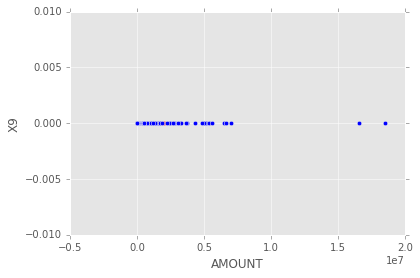

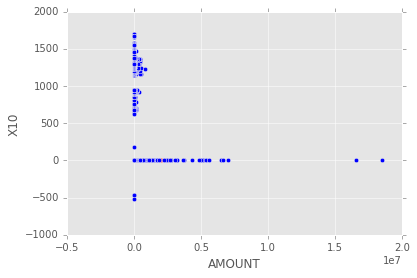

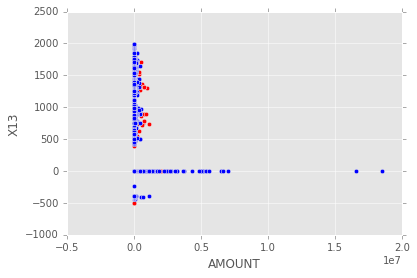

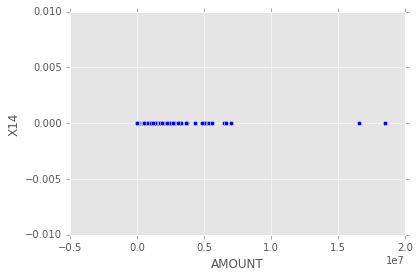

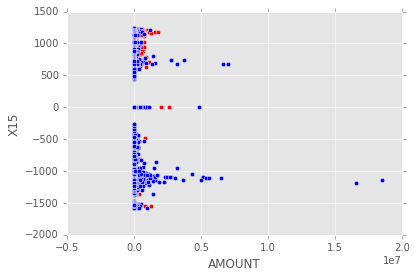

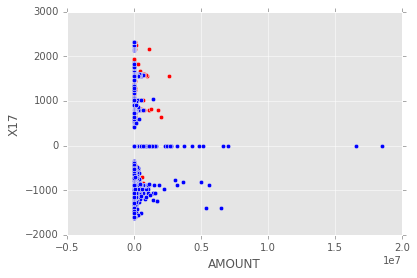

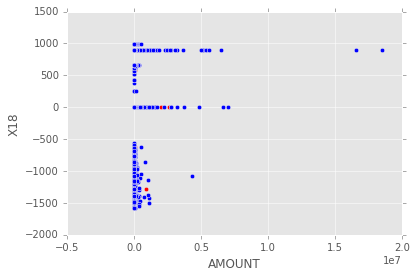

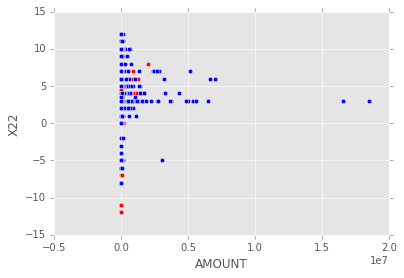

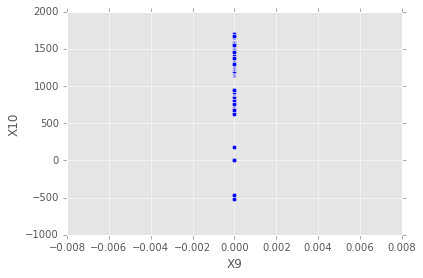

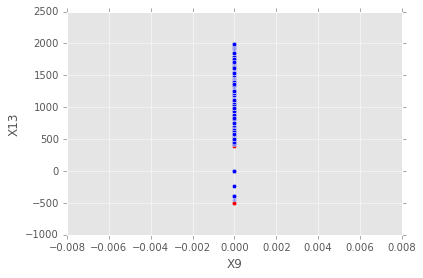

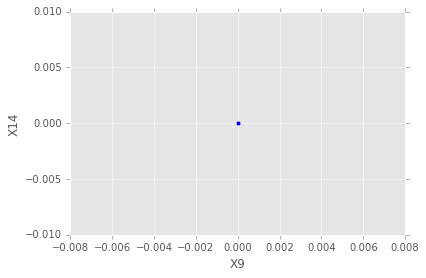

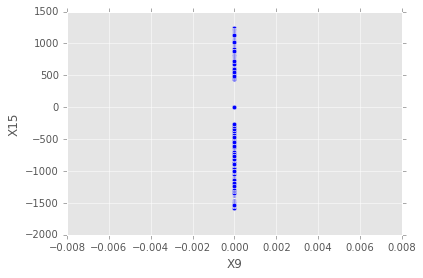

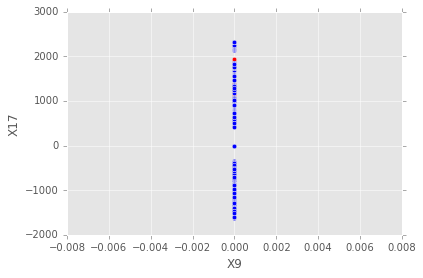

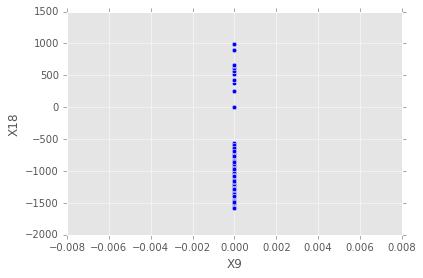

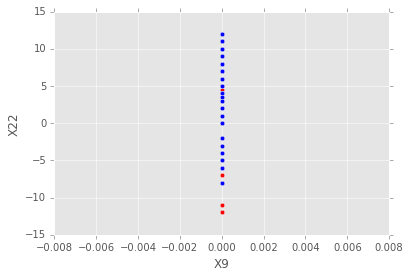

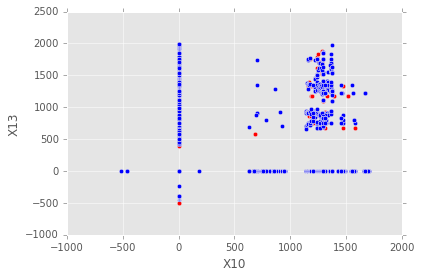

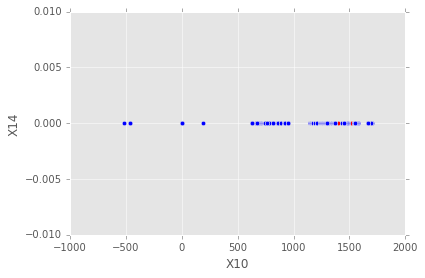

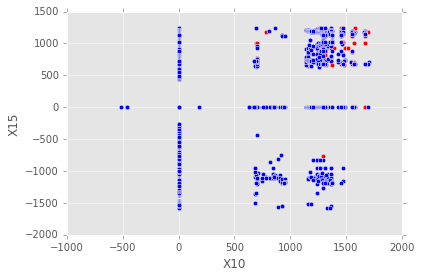

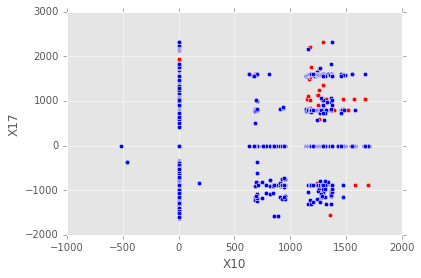

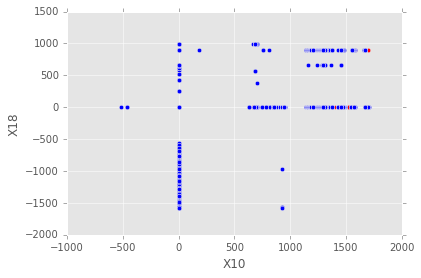

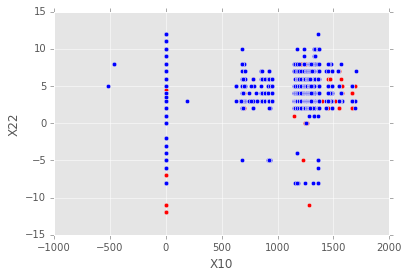

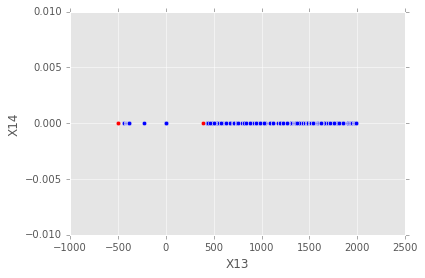

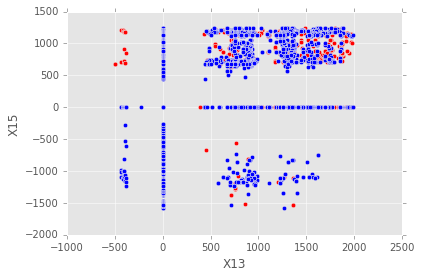

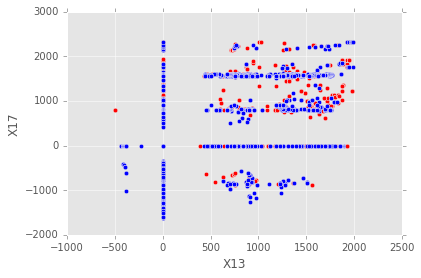

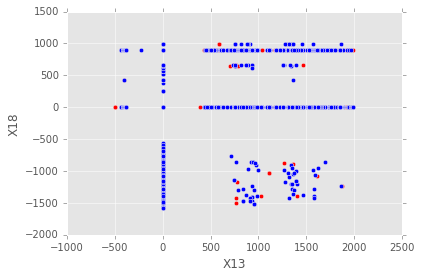

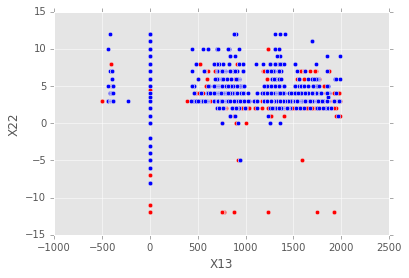

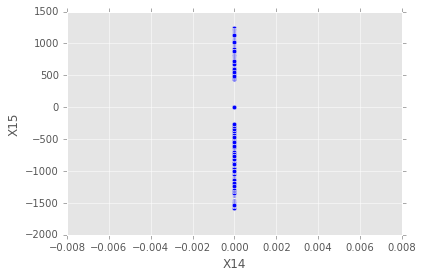

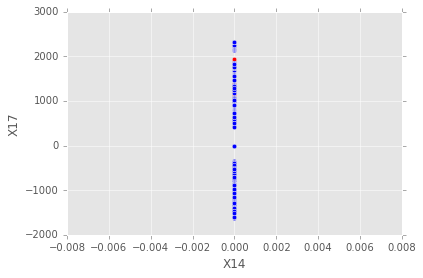

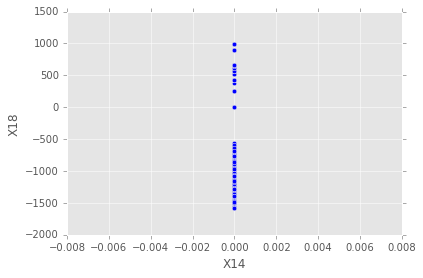

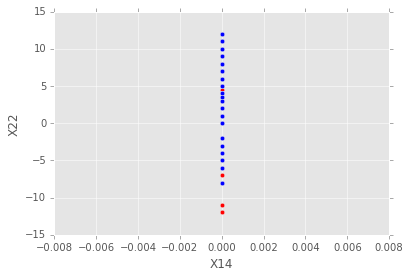

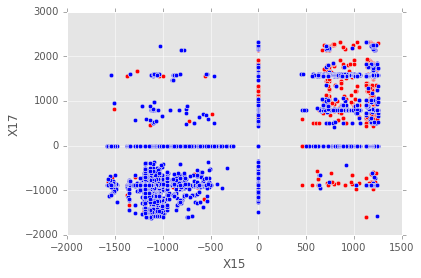

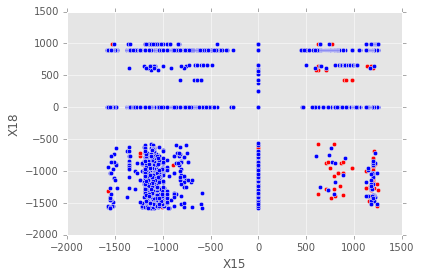

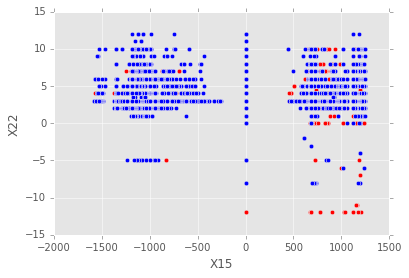

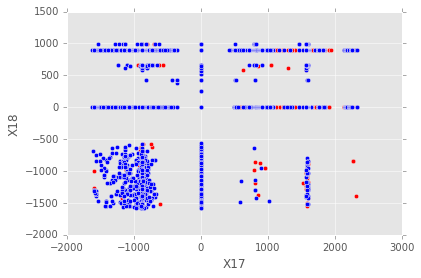

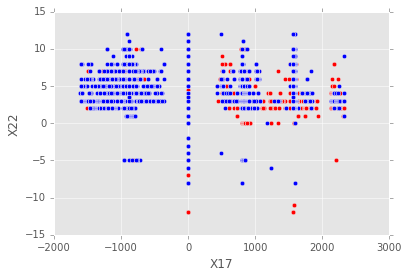

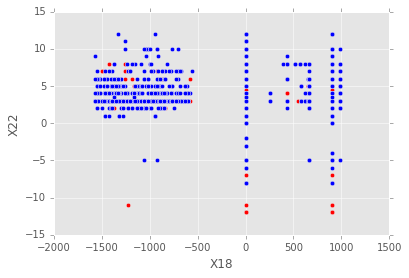

In [144]:
for i,p in enumerate(plot_all_pairs(data)):
    p.get_figure().savefig('plots/{}.jpg'.format(i))

Задача 2.
1. Предположим, что решающее правило >=0.5 – фрод, в остальных случаях – не фрод.
По указанной выборки рассчитать: true positive, false positive, true negative, false
negative для всех правил
2. Для каждой ЭС найдите порог решающего правила, для которого false positive не
более 0.2

In [39]:
def calculate_rates(dataset,system,threshold):
    FP = len(dataset.query('{} >= {} & CLASS == "G"'.format(system, threshold)))
    TP = len(dataset.query('{} >= {} & CLASS == "F"'.format(system, threshold)))
    FN = len(dataset.query('{} < {} & CLASS == "F"' .format(system, threshold)))
    TN = len(dataset.query('{} < {} & CLASS == "G"' .format(system, threshold)))
    return {
        'FP':FP,'TP':TP,'FN':FN,'TN':TN,
        'FP_rate': FP/(FP + TN),
        'TP_rate': TP/(TP + FN),
        'FN_rate': FN/(TP + FN),
        'TN_rate': TN/(TN + FP),   
        'precision': TP/(TP + FP) if TP+FP else 0,   
        'recall': TP/(TP + FN),
    }

for system in range(1,5): # Система 5 обрабатываться не хочет - я не понимаю, почему
    print("System {}:\n{}".format(
            system,
            str(calculate_rates(data,0.5,"p{}_Fraud".format(system)))
        ))

System 1:
{'recall': 0.7276591333195107, 'TN': 7497, 'TP': 7019, 'FN_rate': 0.27234086668048935, 'FP_rate': 0.6079590022486011, 'precision': 0.37645481362295524, 'TN_rate': 0.39204099775139883, 'FN': 2627, 'FP': 11626, 'TP_rate': 0.7276591333195107}
System 2:
{'recall': 0.2799087704748082, 'TN': 8157, 'TP': 2700, 'FN_rate': 0.7200912295251918, 'FP_rate': 0.5734455890812111, 'precision': 0.19757061320064392, 'TN_rate': 0.4265544109187889, 'FN': 6946, 'FP': 10966, 'TP_rate': 0.2799087704748082}
System 3:
{'recall': 0.15633423180592992, 'TN': 5987, 'TP': 1508, 'FN_rate': 0.8436657681940701, 'FP_rate': 0.6869215081315693, 'precision': 0.1029773285987435, 'TN_rate': 0.3130784918684307, 'FN': 8138, 'FP': 13136, 'TP_rate': 0.15633423180592992}
System 4:
{'recall': 0.44432925565001036, 'TN': 6567, 'TP': 4286, 'FN_rate': 0.5556707443499896, 'FP_rate': 0.656591538984469, 'precision': 0.2544828405177532, 'TN_rate': 0.343408461015531, 'FN': 5360, 'FP': 12556, 'TP_rate': 0.44432925565001036}


In [19]:
def find_FP_threshold(dataset, system, required):
    import numpy as np
    for threshold in np.arange(0, 1.0, 0.01):
        res = calculate_rates(dataset, threshold, system)
        if res['FP_rate'] <= required:
            return threshold

for system in range(1,5): # Система 5 обрабатываться не хочет - я не понимаю, почему
    print("System {}:\n{}".format(
            system,
            str(find_FP_threshold(data,"p{}_Fraud".format(system),0.2))
        ))

System 1:
0.0
System 2:
0.0
System 3:
0.0
System 4:
0.0


Задача 3.
1. Постройте ROC кривую для каждого правила.
2. Найдите коэффициент Джини для каждого правила.

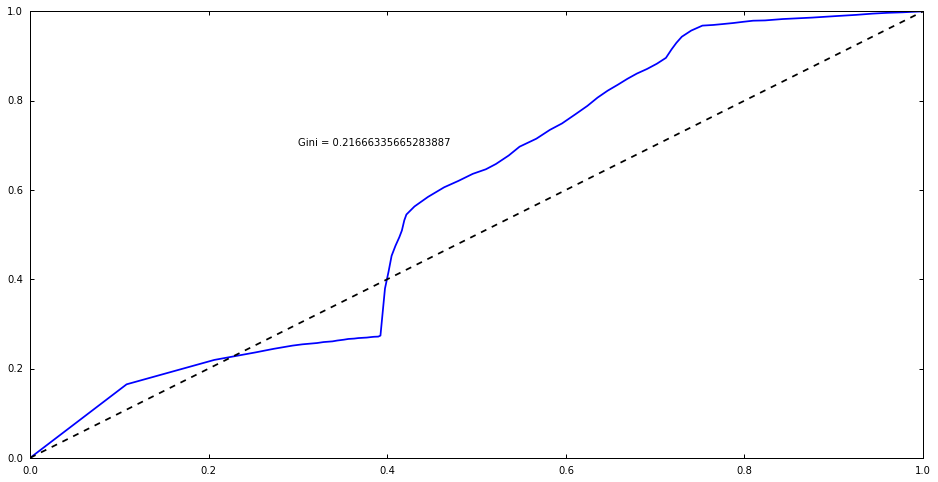

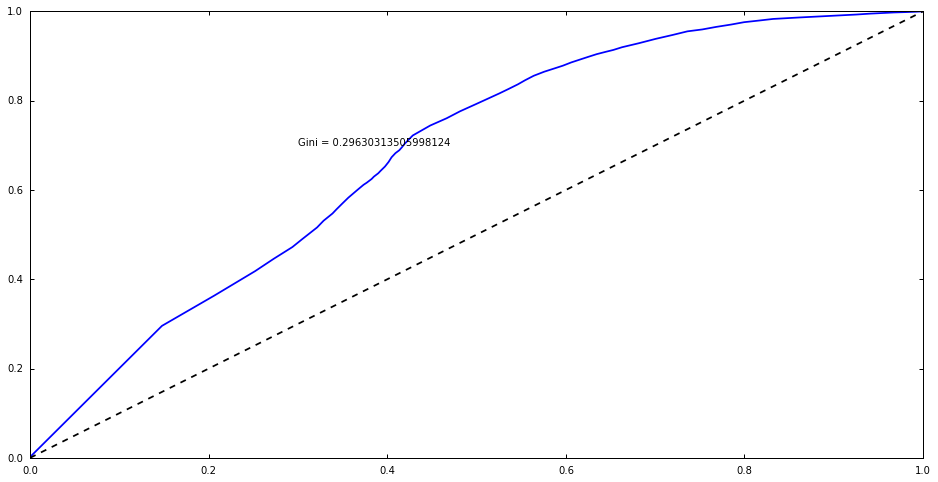

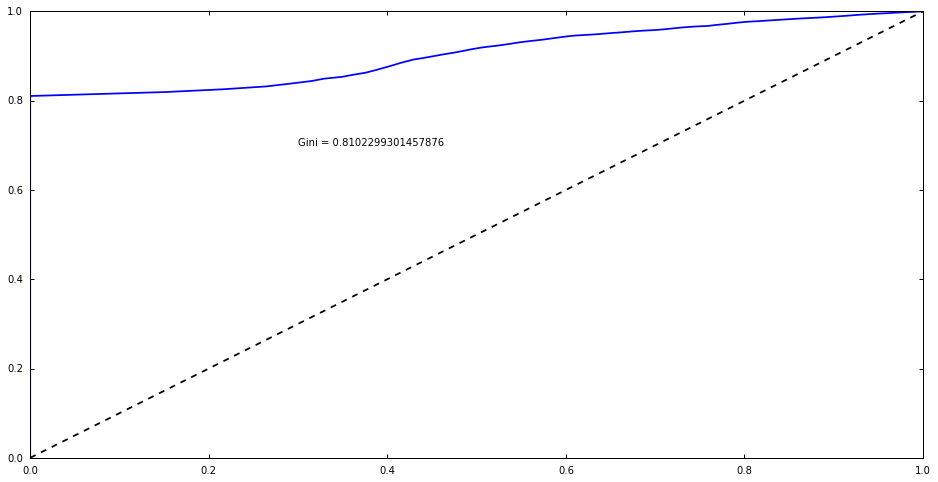

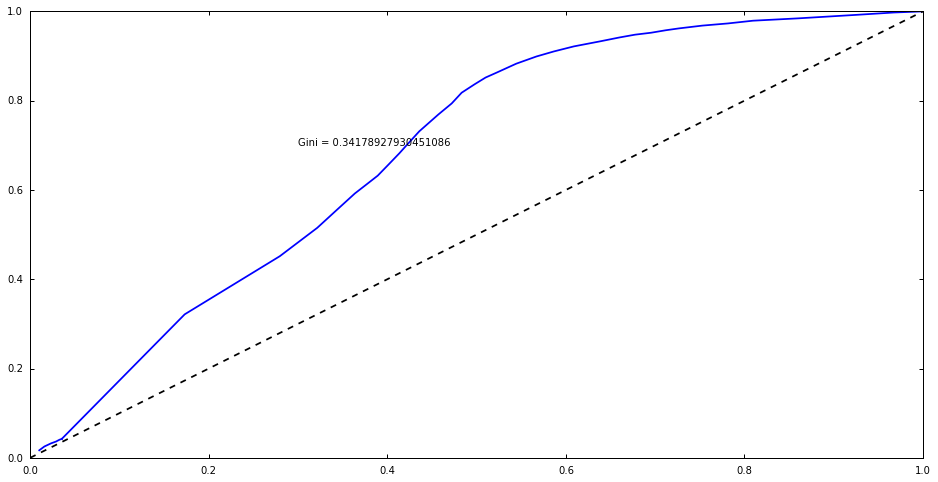

In [46]:
def plot_ROC(dataset,system):
    import numpy as np
    import matplotlib.pyplot as plt # O_o matplotlib is a singleton, so I have to import it several times
    points = [calculate_rates(dataset, system, i) for i in np.arange(0, 1.0, 0.01)]
    apex = max(points, key=lambda x: x['TP_rate'] -  x['FP_rate'])
    gini = apex['TP_rate'] - apex['FP_rate']
    plt.plot([x['FP_rate']for x in points],[x['TP_rate']for x in points])
    plt.plot([0,1],[0,1],"k--")
    plt.text(0.3,0.7,"Gini = {}".format(gini))
    plt.show()

for system in range(1,5): # Система 5 обрабатываться не хочет - я не понимаю, почему
    plot_ROC(data,"p{}_Fraud".format(system))

Задача 4.
1. Создайте ансамбль в виде функции голосования при пороге каждого правила >=0.5, >=0.8. Найдите необходимые пороги для каждого правила ЭС, чтобы false positive ансамбля была минимальна.
2. Создайте ансамбль в виде p = (p1_fraud + p2_fraud + p3_fraud)/3. Постройте ROC
кривую.

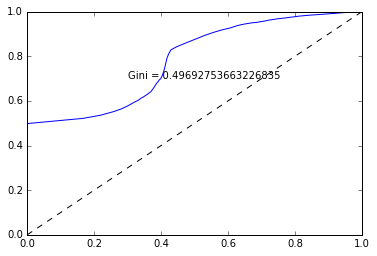

In [23]:
def add_ensemble_row(dataframe, ensemble, name, *columns):
    dataframe[name] = dataframe.apply(lambda row: ensemble(*[row[x] for x in columns]), axis=1)
    return dataframe
    
def ensemble_vote_1(*ps):
    return sum([float(x)>0.5 for x in ps]) > len(ps)/2
    
def ensemble_vote_2(*ps):
    return sum([float(x)>0.8 for x in ps]) > len(ps)/2

def ensemble_average(*ps):
    return sum(ps) / len(ps)

def add_ensembles(dataframe):
    d = dataframe.copy(deep=True)
    d = add_ensemble_row(d,ensemble_vote_1,"p_vote_0.5",'p1_Fraud','p2_Fraud','p3_Fraud')
    d = add_ensemble_row(d,ensemble_vote_2,"p_vote_0.8",'p1_Fraud','p2_Fraud','p3_Fraud')
    d = add_ensemble_row(d,ensemble_average,"p_average" ,'p1_Fraud','p2_Fraud','p3_Fraud')
    return d
    
# > Найдите необходимые пороги для каждого правила ЭС, чтобы false positive ансамбля была минимальна.
# Ответ: 1. False positive == 0, меньше уже никак

def plot_ROC(dataset,system):
    import numpy as np
    import matplotlib.pyplot as plt # O_o matplotlib is a singleton, so I have to import it several times
    points = [calculate_rates(dataset, system, i) for i in np.arange(0, 1.0, 0.01)]
    apex = max(points, key=lambda x: x['TP_rate'] -  x['FP_rate'])
    gini = apex['TP_rate'] - apex['FP_rate']
    plt.plot([x['FP_rate']for x in points],[x['TP_rate']for x in points])
    plt.plot([0,1],[0,1],"k--")
    plt.text(0.3,0.7,"Gini = {}".format(gini))
    plt.show()
    
plot_ROC(add_ensembles(data), "p_average")

Задача 5
1. Зададим ансамбль через параметры A, B, C:
p =(A*p1_fraud+B*p2_fraud+C*p3_fraud)/(A+B+C).
Найдите A, B, C, чтобы индекс Джини ансамбля был бы максимальным. При каких A, B, C индекс Джини минимален? Найдите A, B, C для максимального true positive при условии, что false positive должен быть равен 0.1. Каков порог решающего правила?

In [34]:
def ensemble_ABC(A,B,C):
    def ensemble(*ps):
        return (A*ps[0] + B*ps[1] + C*ps[2]) / (A+B+C)
    return ensemble

def get_gini(dataset,system):
    import numpy as np
    points = [calculate_rates(dataset, system, i) for i in np.arange(0, 1.0, 0.01)]
    apex = max(points, key=lambda x: x['TP_rate'] -  x['FP_rate'])
    return apex['TP_rate'] - apex['FP_rate']

def triplets(precision):
    for A in range(precision):
        for B in range(precision-A):
            yield (A,B,precision-A-B)

def generate_ginis():
    d = data.copy(deep=True)
    i,k = 0,0
    for triplet in triplets(11):
        i+=1
        if i > 5:
            k+=1
            i = 0
        en = ensemble_ABC(*triplet)
        d = add_ensemble_row(d,en,"p_{}_{}_{}_Fraud".format(*triplet),'p1_Fraud','p2_Fraud','p3_Fraud')
        gini = get_gini(d,"p_{}_{}_{}_Fraud".format(*triplet))
        yield triplet + (gini,)
        
def find_min_max(ginis):
    _max = (0,0,0,-1)
    _min = (0,0,0,10)
    for A,B,C,gini in ginis:
        if gini > _max[3]:
            _max = A,B,C,gini
        elif gini < _min[3]:
            _min = A,B,C,gini
    return _min, _max

_min, _max = find_min_max(generate_ginis())
print(("Max gini: A={},B={},C={}: {}\n" +
        "Min gini: A={},B={},C={}: {}") \
      .format(*(_max+_min)))

Progress...0.023809523809523808%
Progress...0.047619047619047616%
Progress...0.07142857142857142%
Progress...0.09523809523809523%
Progress...0.11904761904761904%
Progress...0.14285714285714285%
Progress...0.16666666666666666%
Progress...0.19047619047619047%
Progress...0.21428571428571427%
Progress...0.23809523809523808%
Progress...0.2619047619047619%
Max gini: A=0,B=0,C=11: 0.8102299301457876
Min gini: A=10,B=0,C=1: 0.2413759809704039


Вычисления очень долгие, поэтому оставлю результаты тут

Max gini: A=0,B=0,C=11: 0.8102299301457876

Min gini: A=10,B=0,C=1: 0.2413759809704039

Задача 6.
1. Постройте зависимость точности от pi_fraud для i от 1 до 3 для каждого дня.
2. Аналогично п.1 постройте зависимость полноты от pi_fraud.
3. Найдите SSI

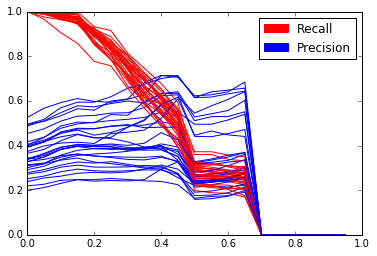

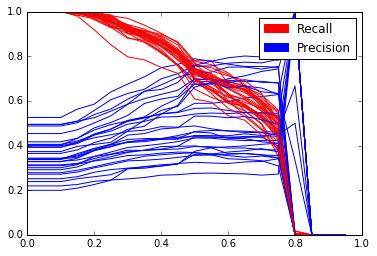

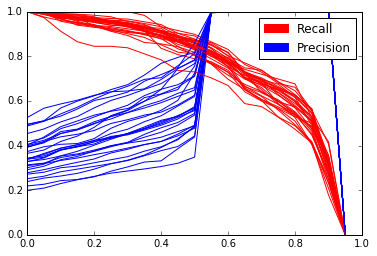

In [41]:
def plot_by_day(ds, system):
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    import numpy as np
    for date in set(ds.EVENT_DATE):
        x = np.arange(0, 1.0, 0.05)
        y_rec = map(lambda i: calculate_rates(ds[ds['EVENT_DATE'] == date], system, i)['recall'], x)
        y_pre = map(lambda i: calculate_rates(ds[ds['EVENT_DATE'] == date], system, i)['precision'], x)
        plt.plot(list(x), list(y_rec), 'r')
        plt.plot(list(x), list(y_pre), 'b')
    red_patch = mpatches.Patch(color='red', label='Recall')
    blue_patch = mpatches.Patch(color='blue', label='Precision')
    plt.legend(handles=[red_patch,blue_patch])
    plt.show()
    
plot_by_day(data,"p1_Fraud")
plot_by_day(data,"p2_Fraud")
plot_by_day(data,"p3_Fraud")